In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

/Users/dushamishkin/VSCProjects/BRI-thesis/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/dushamishkin/VSCProjects/BRI-thesis/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Предварительная подготовка

In [2]:
port_calls = pd.read_csv('../data/port_calls/proc_port_calls.csv').drop(columns=['port_id', 'unloco', 'vessel_name', 'imo', 'time_local'])
port_calls['time_utc'] = pd.to_datetime(port_calls['time_utc']).dt.strftime('%Y-%m-%d')
port_calls['time_utc'] = pd.to_datetime(port_calls['time_utc'])
port_calls['ais_type'] = port_calls['ais_type'].fillna(0).astype(int).astype(str)
# port_calls['ais_type'] = port_calls['ais_type'].apply(lambda x: "C" + x)
port_calls['ais_type'] = port_calls['ais_type'].astype(str)
port_calls['built'] = port_calls['built'].fillna(0).astype(int).astype(str).replace('0', 'N/A')

comm = pd.read_csv('../data/commodities/commodities_cleaned.csv')
comm = comm.drop(columns=['Extra_Column_13'])
comm['Week Start'] = pd.to_datetime(comm['Week Start'])
comm['Week End'] = pd.to_datetime(comm['Week End'])
comm['week'] = comm['Week Start'].dt.strftime('%Y-%m-%d') + ' to ' + comm['Week End'].dt.strftime('%Y-%m-%d')

calendar = comm[['week', 'Week Start', 'Week End']].drop_duplicates()
comm = comm.sort_values(by='Week Start')[['week', 'Week Start', 'Species', 'Weekly Close']]

port_calls['area'] = (port_calls['size_a'] + port_calls['size_b']) * (port_calls['size_c'] + port_calls['size_d'])
port_calls = port_calls.drop(columns=['size_a', 'size_b', 'size_c', 'size_d', 'max_sog', 'dwt'])

In [3]:
expanded_calendar = calendar.apply(
    lambda row: pd.DataFrame({
        'date': pd.date_range(start=row['Week Start'], end=row['Week End']),
        'week': row['week']
    }),
    axis=1
)

expanded_calendar = pd.concat(expanded_calendar.values, ignore_index=True)
expanded_calendar['date'] = pd.to_datetime(expanded_calendar['date'])

In [4]:
port_calls_w = port_calls.merge(expanded_calendar, how='left', left_on='time_utc', right_on='date').drop(columns=['date'])

In [5]:
port_calls_w['event'] = port_calls_w['event'].str.lower()
port_calls_w['event'] = port_calls_w['event'].apply(lambda x: 'EventType_' + x)

# Сужаемся

In [6]:
vessel_countries = pd.read_csv('../data/mapping/countries.csv', delimiter=';')
vessel_countries = vessel_countries[['ISO-alpha2 Code', 'Region Name']]
vessel_countries['Region Name'] = 'VesselFlagRegion_' + vessel_countries['Region Name']
port_calls_l = port_calls_w.merge(vessel_countries, how='left', left_on='flag', right_on='ISO-alpha2 Code').drop(columns=['ISO-alpha2 Code', 'flag'])

In [7]:
port_countries = pd.read_csv('../data/mapping/ports_countries.csv', delimiter=',')
port_countries['country_name'] = 'PortCountry_' + port_countries['country_name']
port_calls_l = port_calls_l.merge(port_countries, how='left', on='port_name').drop(columns=['port_name'])

In [8]:
port_calls_l['built_bins'] = pd.cut(
    pd.to_numeric(port_calls_l['built'], errors='coerce'),
    bins=range(1925, 2050, 25),
    right=False,
    labels=[f"VesselBuiltYear_{i}-{i+24}" for i in range(1925, 2025, 25)]
)
port_calls_l = port_calls_l.drop(columns=['built'])

In [9]:
ais = pd.read_csv('../data/mapping/ais_types.csv', delimiter=',').drop(columns=['Description', 'Group1'])
ais['AIS_Type'] = ais['AIS_Type'].astype(str)

In [10]:
port_calls_l = port_calls_l.merge(ais, how='left', left_on='ais_type', right_on='AIS_Type').drop(columns=['AIS_Type', 'ais_type'])
port_calls_l['ais_group'] = 'VesselTypeAIS_' + port_calls_l['ais_group']

In [11]:
v_types = pd.read_csv('../data/mapping/vessel_types.csv', delimiter=',')
v_types['Group'] = 'VesselTypeGroup_' + v_types['Group']

In [12]:
port_calls_l = port_calls_l.merge(v_types, how='left', left_on='vessel_type', right_on='Class').drop(columns=['Class', 'vessel_type'])  

# Расширяемся

In [13]:
events = port_calls_l.groupby(['week', 'event']).size().reset_index(name='event_count')
events_pivot = events.pivot(index='week', columns='event', values='event_count').fillna(0)
events_pivot = events_pivot.astype(int)

events_pivot.head()

event                     EventType_arrival  EventType_departure
week                                                            
2024-01-01 to 2024-01-07                866                  852
2024-01-08 to 2024-01-14                926                  944
2024-01-15 to 2024-01-21               1232                 1289
2024-01-22 to 2024-01-28               1857                 1852
2024-01-29 to 2024-02-04               1061                 1073

In [14]:
ports = port_calls_l.groupby(['week', 'country_name']).size().reset_index(name='event_count')
ports_pivot = ports.pivot(index='week', columns='country_name', values='event_count').fillna(0)
ports_pivot = ports_pivot.astype(int)

ports_pivot.head()

country_name              PortCountry_Benin  PortCountry_Cameroon  \
week                                                                
2024-01-01 to 2024-01-07                 48                    48   
2024-01-08 to 2024-01-14                 27                    61   
2024-01-15 to 2024-01-21                125                    47   
2024-01-22 to 2024-01-28                179                    58   
2024-01-29 to 2024-02-04                128                    41   

country_name              PortCountry_Côte dIvoire  \
week                                                 
2024-01-01 to 2024-01-07                       103   
2024-01-08 to 2024-01-14                       108   
2024-01-15 to 2024-01-21                       114   
2024-01-22 to 2024-01-28                       105   
2024-01-29 to 2024-02-04                        94   

country_name              PortCountry_Democratic Republic of the Congo  \
week                                                                     
2024-01-01 to 2024-01-07                                             6   
2024-01-08 to 2024-01-14                                             8   
2024-01-15 to 2024-01-21                                             5   
2024-01-22 to 2024-01-28                                             5   
2024-01-29 to 2024-02-04                                             5   

country_name              PortCountry_Djibouti  PortCountry_Egypt  \
week                                                                
2024-01-01 to 2024-01-07                    57                 65   
2024-01-08 to 2024-01-14                    47                 67   
2024-01-15 to 2024-01-21                    46                 95   
2024-01-22 to 2024-01-28                    42                 60   
2024-01-29 to 2024-02-04                    55                 54   

country_name              PortCountry_Gabon  PortCountry_Ghana  \
week                                                             
2024-01-01 to 2024-01-07                 52                 78   
2024-01-08 to 2024-01-14                 67                 77   
2024-01-15 to 2024-01-21                 70                 89   
2024-01-22 to 2024-01-28                 71                 94   
2024-01-29 to 2024-02-04                 42                 91   

country_name              PortCountry_Guinea  PortCountry_Kenya  ...  \
week                                                             ...   
2024-01-01 to 2024-01-07                  23                  0  ...   
2024-01-08 to 2024-01-14                  23                  0  ...   
2024-01-15 to 2024-01-21                  24                333  ...   
2024-01-22 to 2024-01-28                  24                520  ...   
2024-01-29 to 2024-02-04                  24                148  ...   

country_name              PortCountry_Madagascar  PortCountry_Morocco  \
week                                                                    
2024-01-01 to 2024-01-07                      38                  123   
2024-01-08 to 2024-01-14                      86                  139   
2024-01-15 to 2024-01-21                      38                   93   
2024-01-22 to 2024-01-28                      42                  124   
2024-01-29 to 2024-02-04                      38                  120   

country_name              PortCountry_Mozambique  PortCountry_Namibia  \
week                                                                    
2024-01-01 to 2024-01-07                     141                  109   
2024-01-08 to 2024-01-14                     154                  184   
2024-01-15 to 2024-01-21                     131                  172   
2024-01-22 to 2024-01-28                     135                   92   
2024-01-29 to 2024-02-04                     162                   97   

country_name              PortCountry_Republic of the Congo  \
week                                                          
2024-01-01 to 20

In [15]:
types = port_calls_l.groupby(['week', 'Group']).size().reset_index(name='event_count')
types_pivot = types.pivot(index='week', columns='Group', values='event_count').fillna(0)
types_pivot = types_pivot.astype(int)

In [16]:
ais_types = port_calls_l.groupby(['week', 'ais_group']).size().reset_index(name='event_count')
ais_types_pivot = ais_types.pivot(index='week', columns='ais_group', values='event_count').fillna(0)
ais_types_pivot = ais_types_pivot.astype(int)

In [17]:
flags = port_calls_l.groupby(['week', 'Region Name']).size().reset_index(name='event_count')
flags_pivot = flags.pivot(index='week', columns='Region Name', values='event_count').fillna(0)
flags_pivot = flags_pivot.astype(int)

In [18]:
built = port_calls_l.groupby(['week', 'built_bins']).size().reset_index(name='event_count')
built_pivot = built.pivot(index='week', columns='built_bins', values='event_count').fillna(0)
built_pivot = built_pivot.astype(int)

/var/folders/0w/y2wjb705539ckxrjgz4jqckc0000gn/T/ipykernel_38659/2776782556.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  built = port_calls_l.groupby(['week', 'built_bins']).size().reset_index(name='event_count')


In [19]:
continious_grouped = port_calls_w.groupby('week').agg(
    VesselAvgArea=('area', 'mean'),
    VesselAvgGt=('gt', 'mean'),
    VesselAvgSog=('avg_sog', 'mean')
).reset_index()

# Новости

In [20]:
files = ["2022-12-14.csv", "2023-12-01.csv", "2024-12-19.csv"]

dataframes = [pd.read_csv(os.path.join("../data/news", file)) for file in files]
news = pd.concat(dataframes, ignore_index=True)

news = news[news['datetime'].str.match(r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}$', na=False)]
news['datetime'] = pd.to_datetime(news['datetime'])

news = news.drop_duplicates(subset=['text', 'title'])
news.dropna(inplace=True)
news = news[news.datetime >= '2023-01-01']
news['datetime'] = news['datetime'].dt.floor('D')

news = news.merge(expanded_calendar, how='left', left_on='datetime', right_on='date').drop(columns=['date', 'datetime', 'title'])

news.head()

text                      week
0  12月1日，央行公布2023年11月常备借贷便利开展情况。为满足金融机构临时性流动性需求，2...  2023-11-27 to 2023-12-03
1  2023年11月29日，第六届社会责任大会暨“2023奥纳奖颁奖典礼”在北京召开。凭借多年来...  2023-11-27 to 2023-12-03
2  中央金融工作会议强调，要加快建设金融强国，全面加强金融监管，完善金融体制，优化金融服务，防范...  2023-11-27 to 2023-12-03
3  数字经济时代，新技术浪潮正在深刻改变银行业的运营模式和服务方式，同时也为银行业融入“数字中国...  2023-11-27 to 2023-12-03
4  近日，浙商银行、建设银行、交通银行等多家银行（拟）召开房企座谈会，市场对于新一轮房企融资支持...  2023-11-27 to 2023-12-03

In [21]:
from transformers import pipeline

model_id = "yiyanghkust/finbert-tone-chinese"
classifier = pipeline(
    "sentiment-analysis",
    model=model_id,
    tokenizer=model_id,
    device=1
)

Device set to use mps:1


In [24]:
def classify_article(text):
    chunk_size = 500
    chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]
    scores = []
    
    for chunk in chunks:
        sentiment = classifier(chunk)[0]['label']
        if sentiment == 'Negative':
            scores.append(-1)
        elif sentiment == 'Neutral':
            scores.append(0)
        elif sentiment == 'Positive':
            scores.append(1)
    
    return sum(scores) / len(scores) if scores else 0

news['sentiment_score'] = news['text'].apply(classify_article)

In [26]:
news.head()

text  \
0  12月1日，央行公布2023年11月常备借贷便利开展情况。为满足金融机构临时性流动性需求，2...   
1  2023年11月29日，第六届社会责任大会暨“2023奥纳奖颁奖典礼”在北京召开。凭借多年来...   
2  中央金融工作会议强调，要加快建设金融强国，全面加强金融监管，完善金融体制，优化金融服务，防范...   
3  数字经济时代，新技术浪潮正在深刻改变银行业的运营模式和服务方式，同时也为银行业融入“数字中国...   
4  近日，浙商银行、建设银行、交通银行等多家银行（拟）召开房企座谈会，市场对于新一轮房企融资支持...   

                       week  sentiment_score  
0  2023-11-27 to 2023-12-03         1.000000  
1  2023-11-27 to 2023-12-03         1.000000  
2  2023-11-27 to 2023-12-03         0.857143  
3  2023-11-27 to 2023-12-03         1.000000  
4  2023-11-27 to 2023-12-03         1.000000

In [30]:
news_grouped = news.groupby('week').agg({'sentiment_score':'mean'})
news_grouped.head()

sentiment_score
week                                     
2023-01-02 to 2023-01-08         0.433649
2023-01-09 to 2023-01-15         0.666705
2023-01-16 to 2023-01-22         0.456236
2023-01-30 to 2023-02-05         0.382353
2023-02-06 to 2023-02-12         0.424471

# Lag


In [33]:
assets_dict = pd.read_csv('../data/mapping/assets_dict.csv')
df = comm.copy()
df['Species Code'] = df['Species'].apply(lambda x: x[:2])
df = df.merge(assets_dict, how='left', left_on='Species Code', right_on='code').drop(columns=['code', 'Species Code'])

In [34]:
assets = set([x[:2] for x in df['Species'].tolist()])
targets = df[['week']].drop_duplicates()

for asset in assets:
    subset = df[df['Species'].str[:2] == asset].copy()
    asset_name = subset['name'].unique()[0]
    subset = subset.pivot(index='week', columns='Species', values='Weekly Close')
    subset[f'{asset_name}'] = subset.mean(axis=1)
    subset = subset.drop(columns=[x for x in subset.columns if x != f"{asset_name}"])
    # subset = subset.rename(columns={x: x[:2] for x in subset.columns})
    targets = pd.merge(targets, subset, how='left', on='week')


In [35]:
cols = targets.columns.tolist()
lags = [1, 2, 3]
for lag in lags:
    for c in cols:
        if c != 'week':
            targets[f'{c}_lag{lag}'] = targets[c].shift(-lag)

In [36]:
lag0 = targets[[col for col in targets.columns if '_lag' not in col or col[:4] == 'week']]
lag1 = targets[[col for col in targets.columns if '_lag1' in col or col[:4] == 'week']]
lag2 = targets[[col for col in targets.columns if '_lag2' in col or col[:4] == 'week']]
lag3 = targets[[col for col in targets.columns if '_lag3' in col or col[:4] == 'week']]

In [37]:
targets.head()

week  BURADIENE RUBBER            TIN   CRUDE OIL  \
0  2023-01-02 to 2023-01-08               NaN  209084.166667  564.050000   
1  2023-01-09 to 2023-01-15               NaN  205432.500000  526.483333   
2  2023-01-16 to 2023-01-22               NaN  225209.166667  541.262500   
3  2023-01-30 to 2023-02-05               NaN  235316.363636  550.958333   
4  2023-02-06 to 2023-02-12               NaN  218055.833333  520.590000   

        SILVER    COPPER(BC)  STEEL WIRE ROD         LSFO  HOT ROLLED COIL  \
0  5424.250000  58343.333333          4799.0  4015.000000      4089.916667   
1  5284.583333  59020.000000          4870.0  3698.285714      4137.909091   
2  5329.333333  61428.000000          4849.0  3959.000000      4122.750000   
3  5237.666667  62244.000000          4919.0  4067.454545      4085.166667   
4  5043.833333  60945.000000          4803.0  3913.000000      4070.916667   

          NICKEL  ...     LEAD_lag3  STAINLESS STEEL_lag3  \
0  215529.166667  ...  15309.166667          17042.500000   
1  203047.272727  ...  15335.714286          16670.416667   
2  193935.833333  ...  15282.142857          16334.583333   
3  214920.000000  ...  15248.750000          16314.583333   
4  203865.454545  ...  15404.000000          16044.583333   

   NATURAL RUBBER_lag3     ZINC_lag3    TSR20_lag3  GOLD_lag3  BITUMEN_lag3  \
0              13190.5  24187.916667  10352.500000    422.380   3847.062500   
1              12787.0  23237.500000  10005.625000    415.105   3754.200000   
2              12612.0  22756.666667   9752.500000    414.615   3764.066667   
3              12667.0  22930.000000  10164.285714    413.775   3661.333333   
4              12667.5  23087.500000  10287.142857    415.325   3695.714286   

   SCFIS_lag3  ALUMINIUM_lag3  COPPER_lag3  
0         NaN    19124.166667      69327.5  
1         NaN    19026.250000      68072.5  
2         NaN    18551.666667      67975.0  
3         NaN    18724.166667      69215.0  
4         NaN    18645.833333      69852.5  

[5 rows x 93 columns]

# Report

In [38]:
df = ports_pivot.merge(events_pivot, how='left', on='week')
df = df.merge(types_pivot, how='left', on='week')
# df = df.merge(ais_types_pivot, how='left', on='week')
df = df.merge(flags_pivot, how='left', on='week')  
df = df.merge(built_pivot, how='left', on='week')
df = df.merge(continious_grouped, how='left', on='week') 
df = df.merge(news_grouped, how='left', on='week')


df_l0 = df.merge(lag0, how='left', on='week')
df_l1 = df.merge(lag1, how='left', on='week')
df_l2 = df.merge(lag2, how='left', on='week')
df_l3 = df.merge(lag3, how='left', on='week')

In [50]:
final_df = df.merge(targets, how='left', on='week')
final_df.to_csv('../data/final_df.csv')

In [39]:
df_l1.head()

week  PortCountry_Benin  PortCountry_Cameroon  \
0  2024-01-01 to 2024-01-07                 48                    48   
1  2024-01-08 to 2024-01-14                 27                    61   
2  2024-01-15 to 2024-01-21                125                    47   
3  2024-01-22 to 2024-01-28                179                    58   
4  2024-01-29 to 2024-02-04                128                    41   

   PortCountry_Côte dIvoire  PortCountry_Democratic Republic of the Congo  \
0                       103                                             6   
1                       108                                             8   
2                       114                                             5   
3                       105                                             5   
4                        94                                             5   

   PortCountry_Djibouti  PortCountry_Egypt  PortCountry_Gabon  \
0                    57                 65                 52   
1                    47                 67                 67   
2                    46                 95                 70   
3                    42                 60                 71   
4                    55                 54                 42   

   PortCountry_Ghana  PortCountry_Guinea  ...     LEAD_lag1  \
0                 78                  23  ...  16127.916667   
1                 77                  23  ...  16162.500000   
2                 89                  24  ...  16313.750000   
3                 94                  24  ...  16156.666667   
4                 91                  24  ...  16171.666667   

   STAINLESS STEEL_lag1  NATURAL RUBBER_lag1     ZINC_lag1    TSR20_lag1  \
0          13662.916667              13512.0  21035.000000  10895.714286   
1          13884.166667              13838.5  21031.363636  11207.500000   
2          14123.750000              13712.5  20537.500000  11214.285714   
3          13728.333333              13547.5  20726.250000  11160.555556   
4          13632.916667              13561.5  20394.583333  11116.666667   

   GOLD_lag1  BITUMEN_lag1  SCFIS_lag1  ALUMINIUM_lag1   COPPER_lag1  
0   482.6375   3670.000000     1902.70    19068.750000  68064.166667  
1   482.4950   3690.600000     1769.34    18817.083333  67496.666667  
2   479.8850   3706.583333     1676.70    18633.333333  67685.833333  
3   483.7150   3690.875000     1571.86    18762.500000  68703.333333  
4   482.4275   3672.923077     1451.20    18638.333333  68312.500000  

[5 rows x 70 columns]

In [44]:
profile_l0 = ProfileReport(df_l0, title="Lag 0 report")
profile_l1 = ProfileReport(df_l1, title="Lag 1 report")
profile_l2 = ProfileReport(df_l2, title="Lag 2 report")
profile_l3 = ProfileReport(df_l3, title="Lag 3 report")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [45]:
profile_l0.to_file("../misc/reports/lag0_report.html")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


In [46]:
profile_l1.to_file("../misc/reports/lag1_report.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


In [47]:
profile_l2.to_file("../misc/reports/lag2_report.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


In [48]:
profile_l3.to_file("../misc/reports/lag3_report.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


# Корреляции

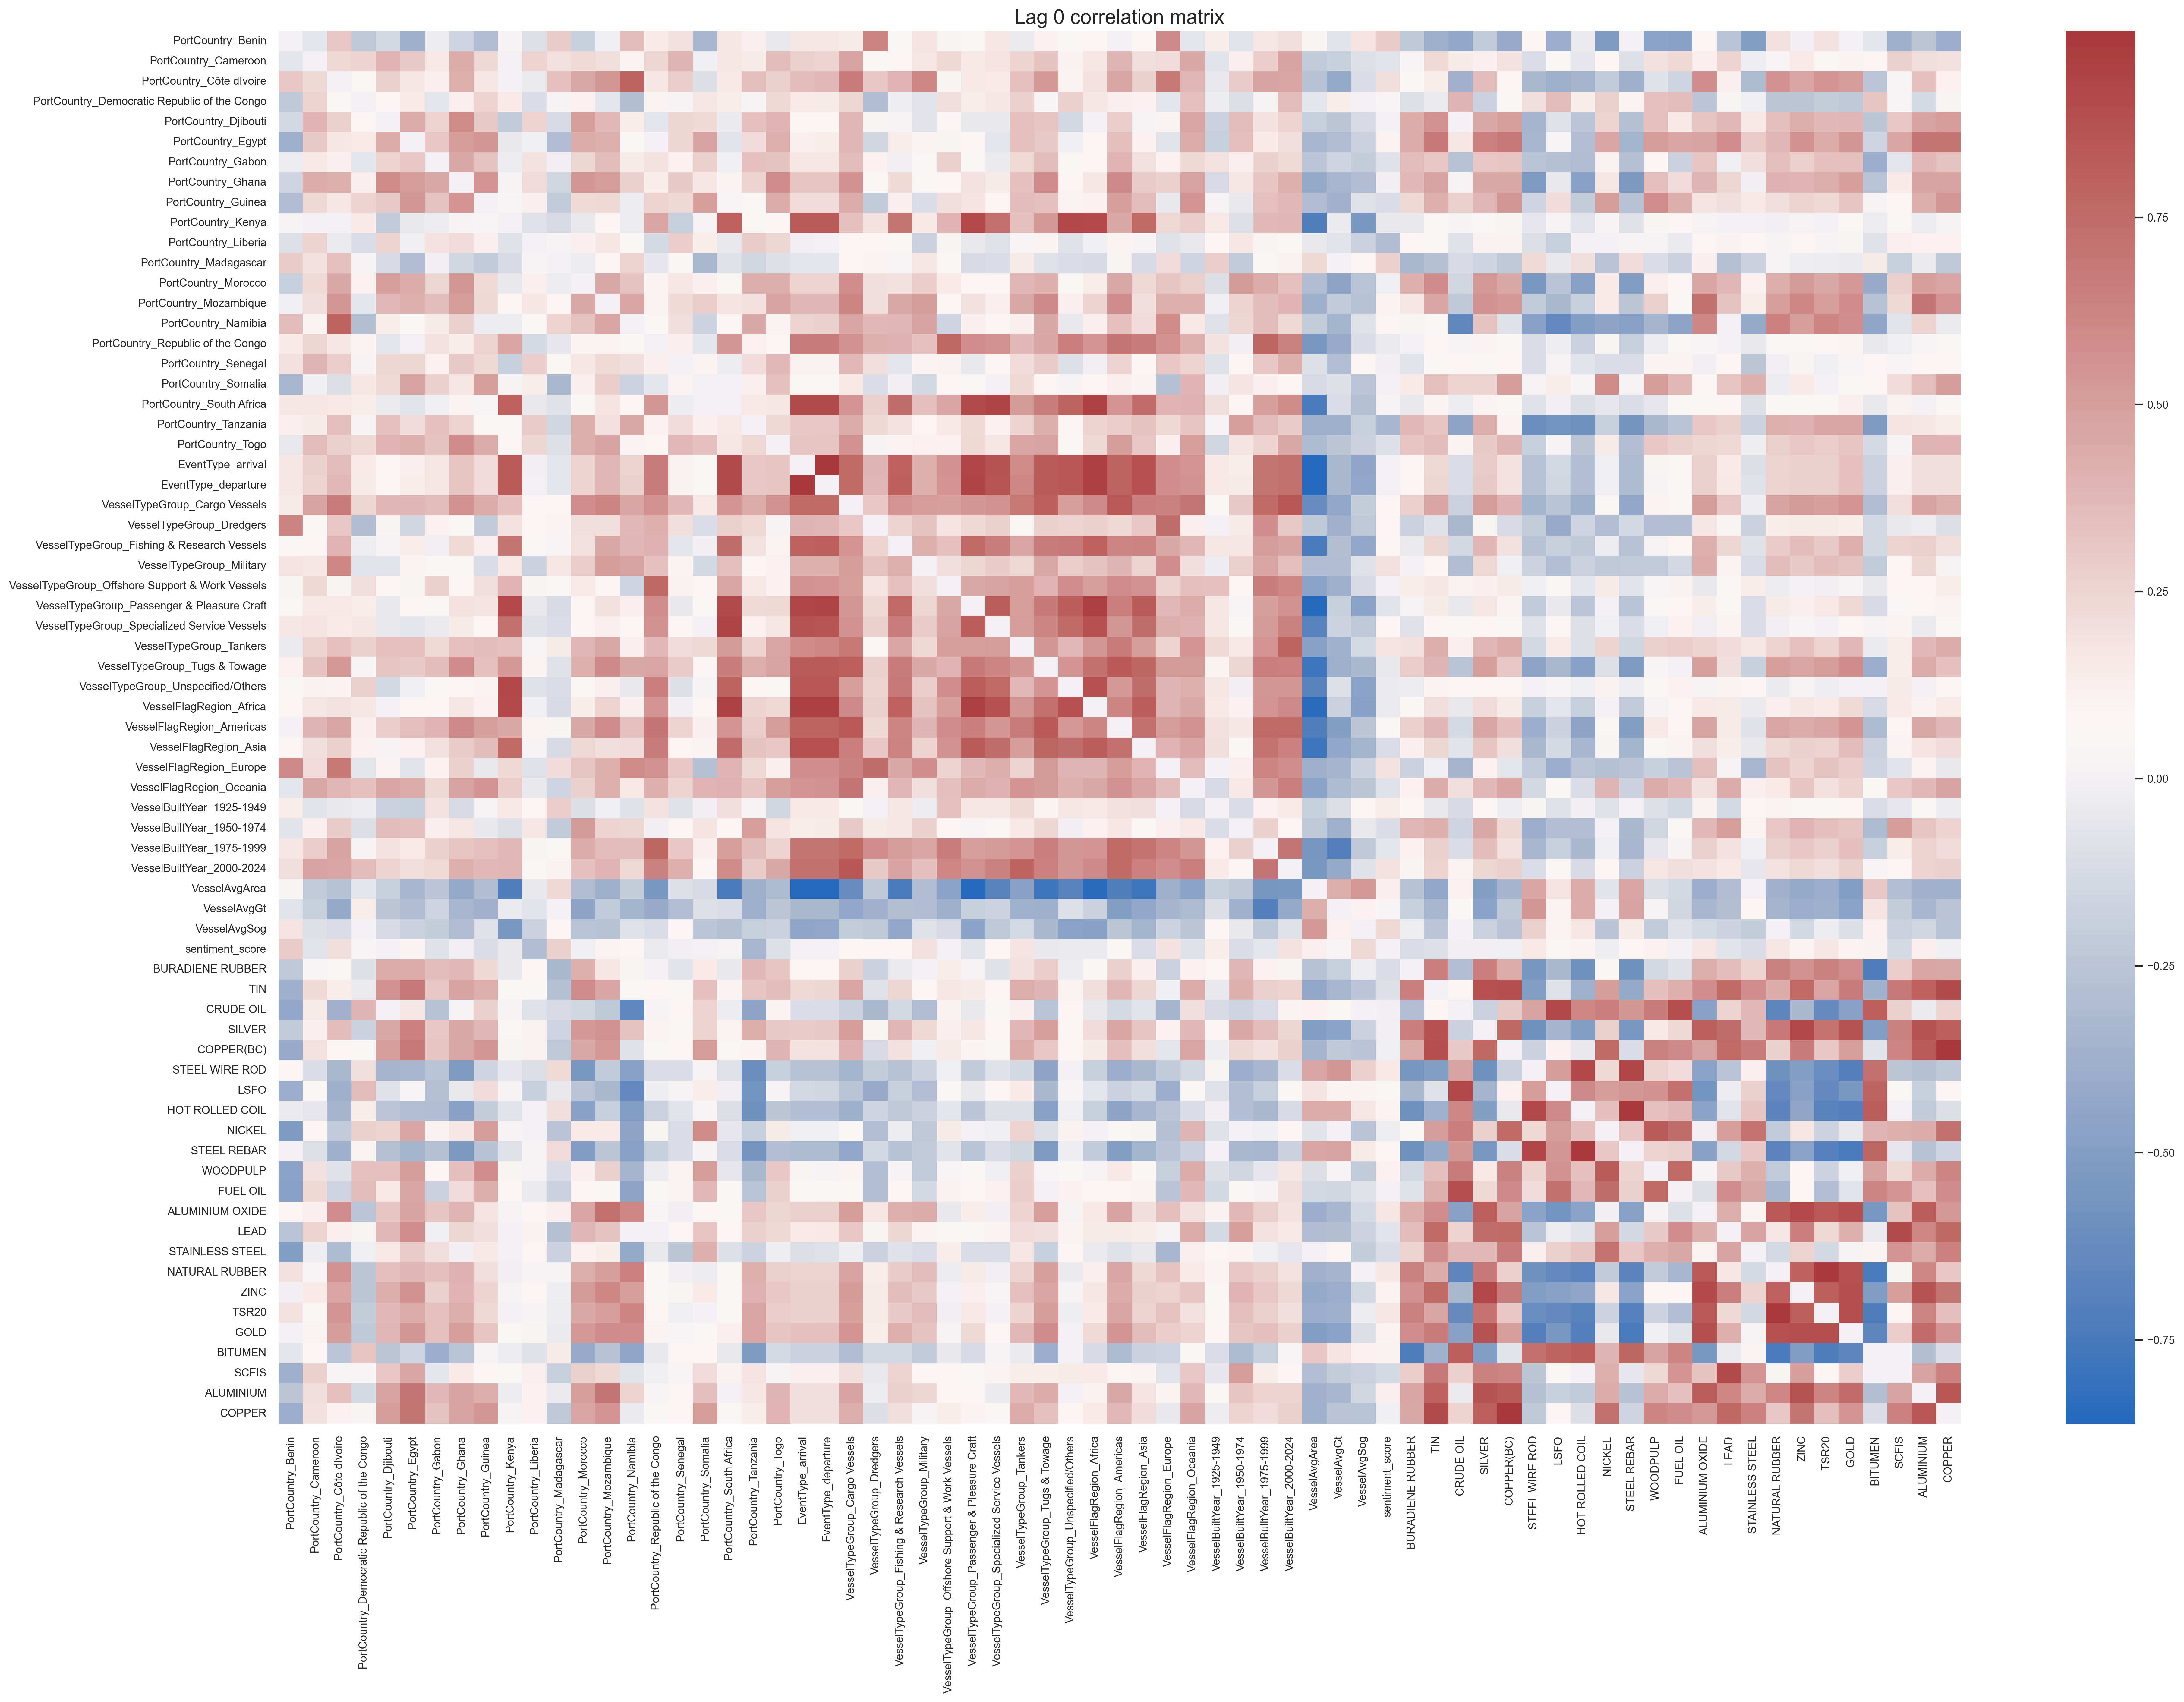

In [40]:
co_mtx = df_l0.corr(numeric_only=True)
co_mtx = co_mtx - np.eye(co_mtx.shape[0])

sns.set(font_scale=0.8)
plt.figure(figsize=(30, 20), dpi=300)
plt.title('Lag 0 correlation matrix', fontdict={'size': 16})
sns.heatmap(co_mtx, cmap="vlag", annot=False)
plt.savefig("../misc/images/Lag0_correlation_heatmap.png")

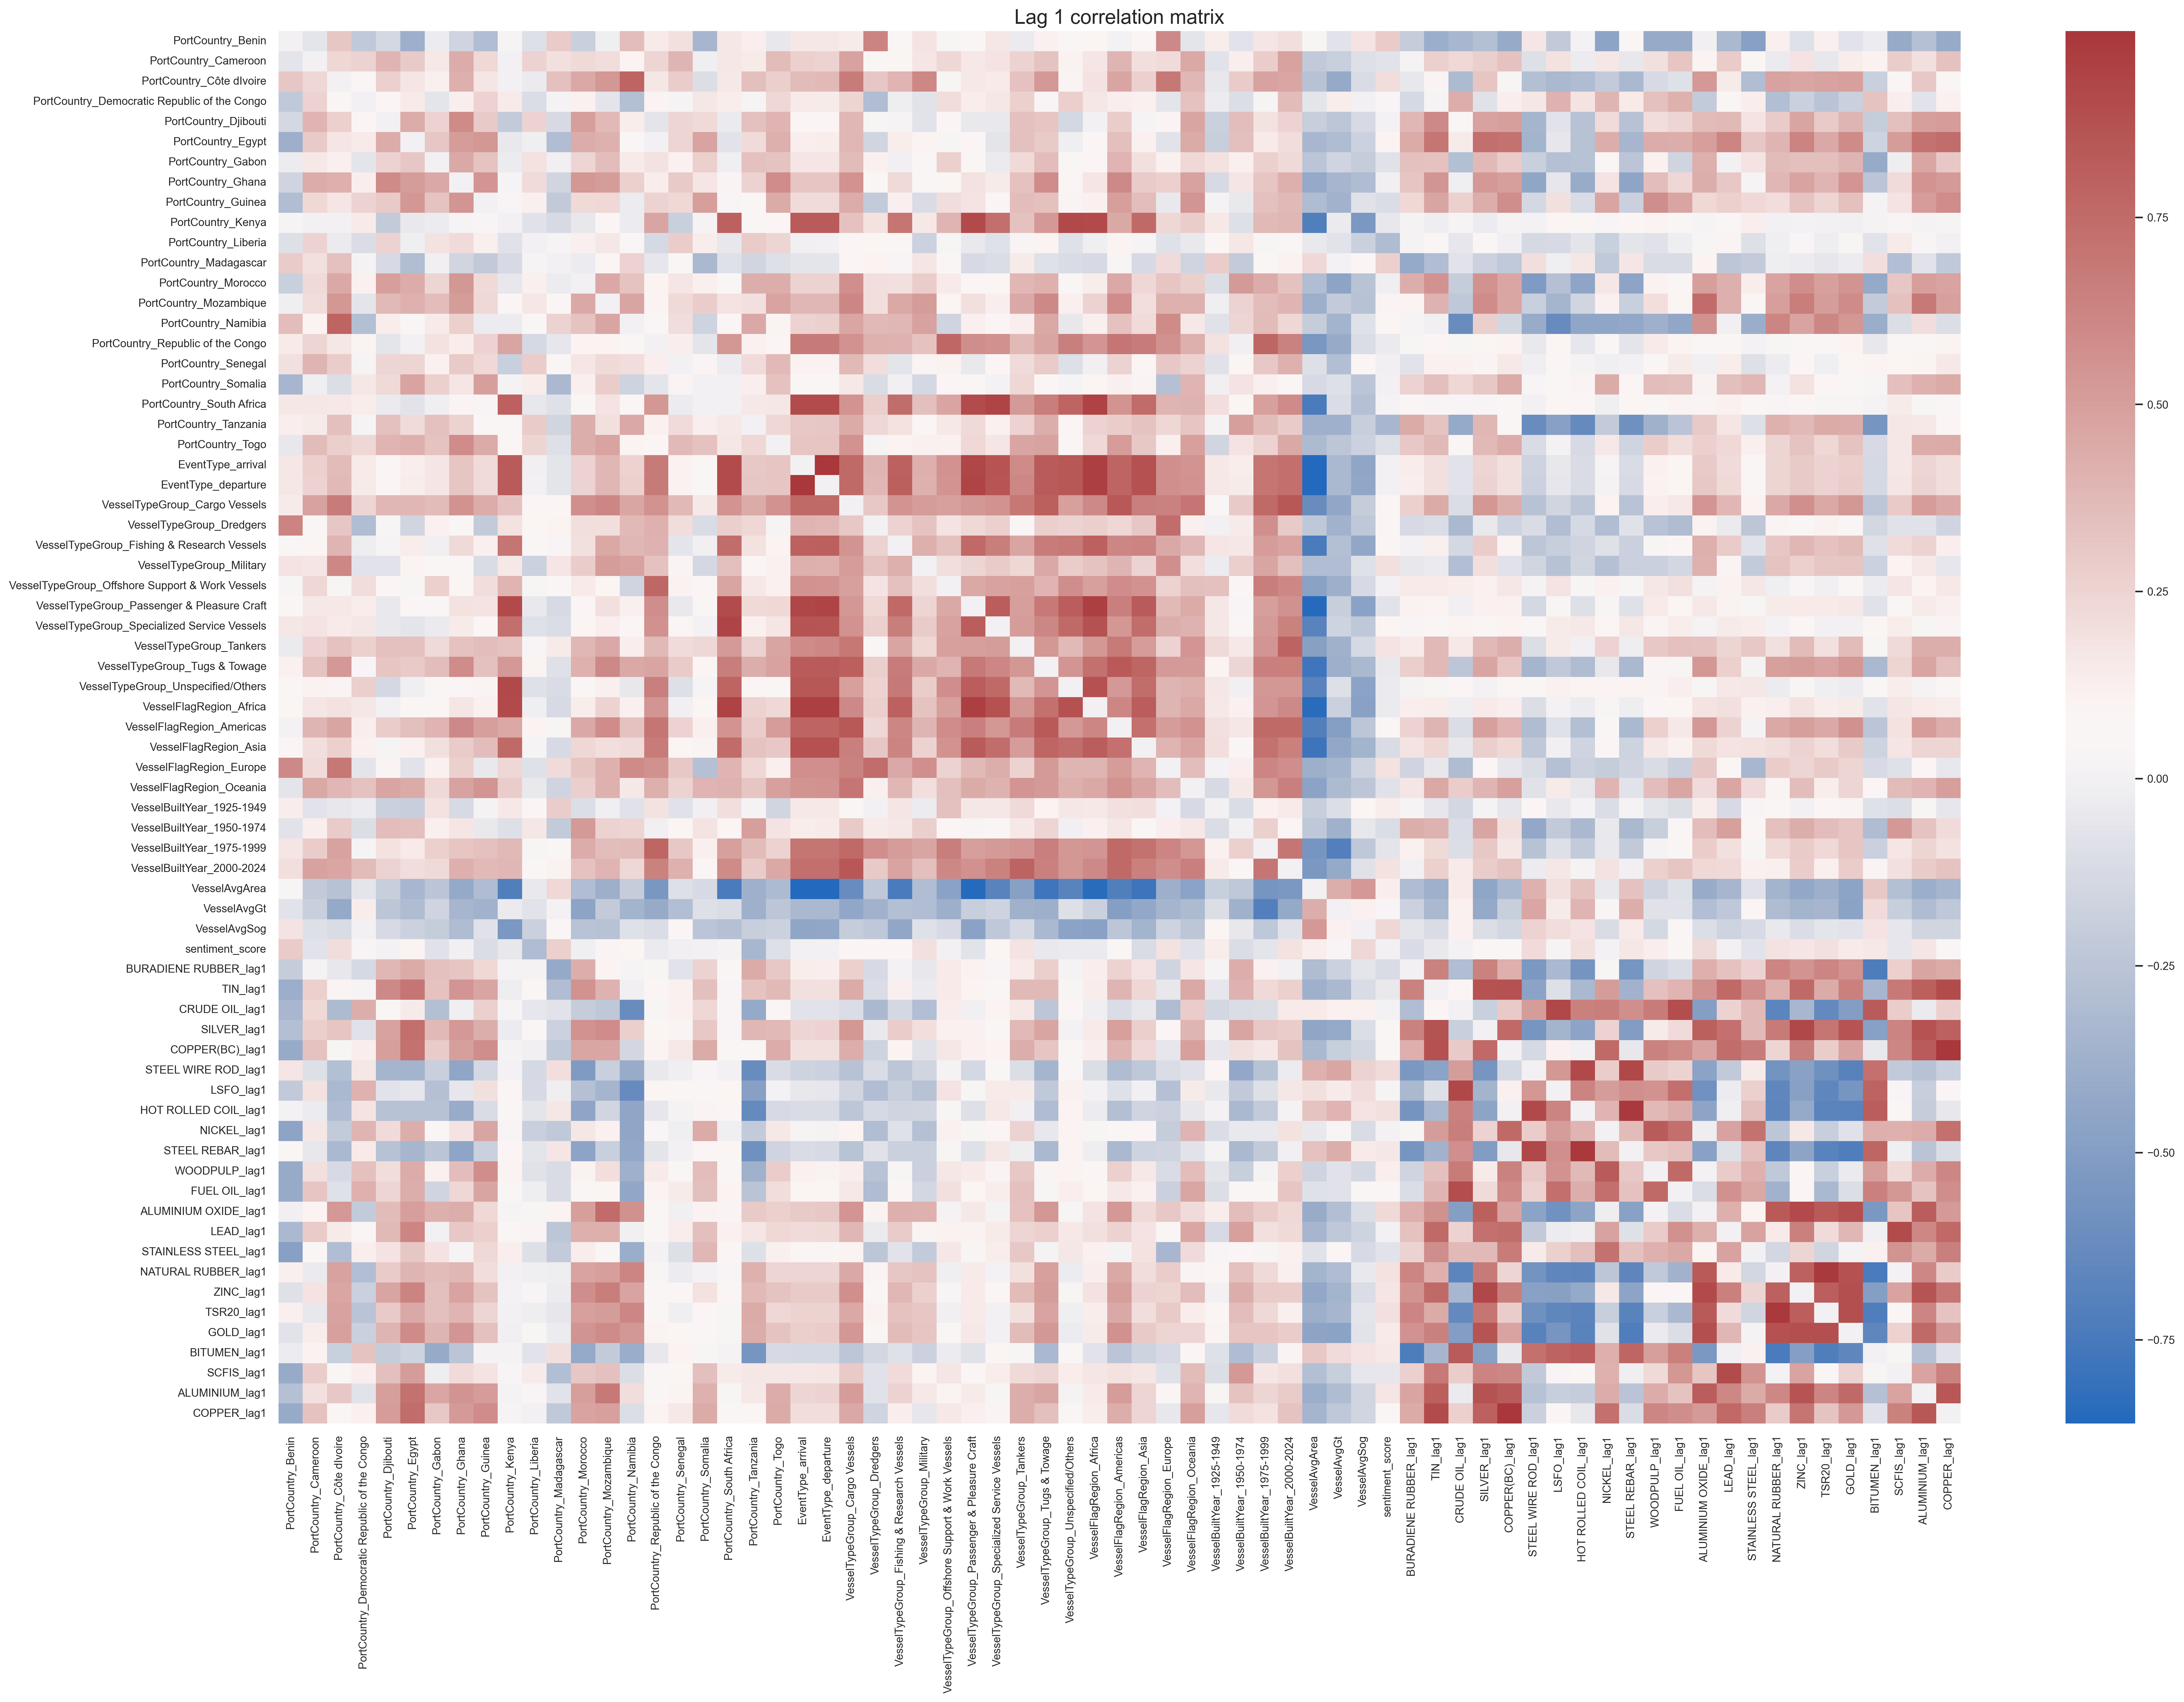

In [41]:
co_mtx = df_l1.corr(numeric_only=True)
co_mtx = co_mtx - np.eye(co_mtx.shape[0])

sns.set(font_scale=0.8)
plt.figure(figsize=(30, 20), dpi=300)
plt.title('Lag 1 correlation matrix', fontdict={'size': 16})
sns.heatmap(co_mtx, cmap="vlag", annot=False)
plt.savefig("../misc/images/Lag1_correlation_heatmap.png")

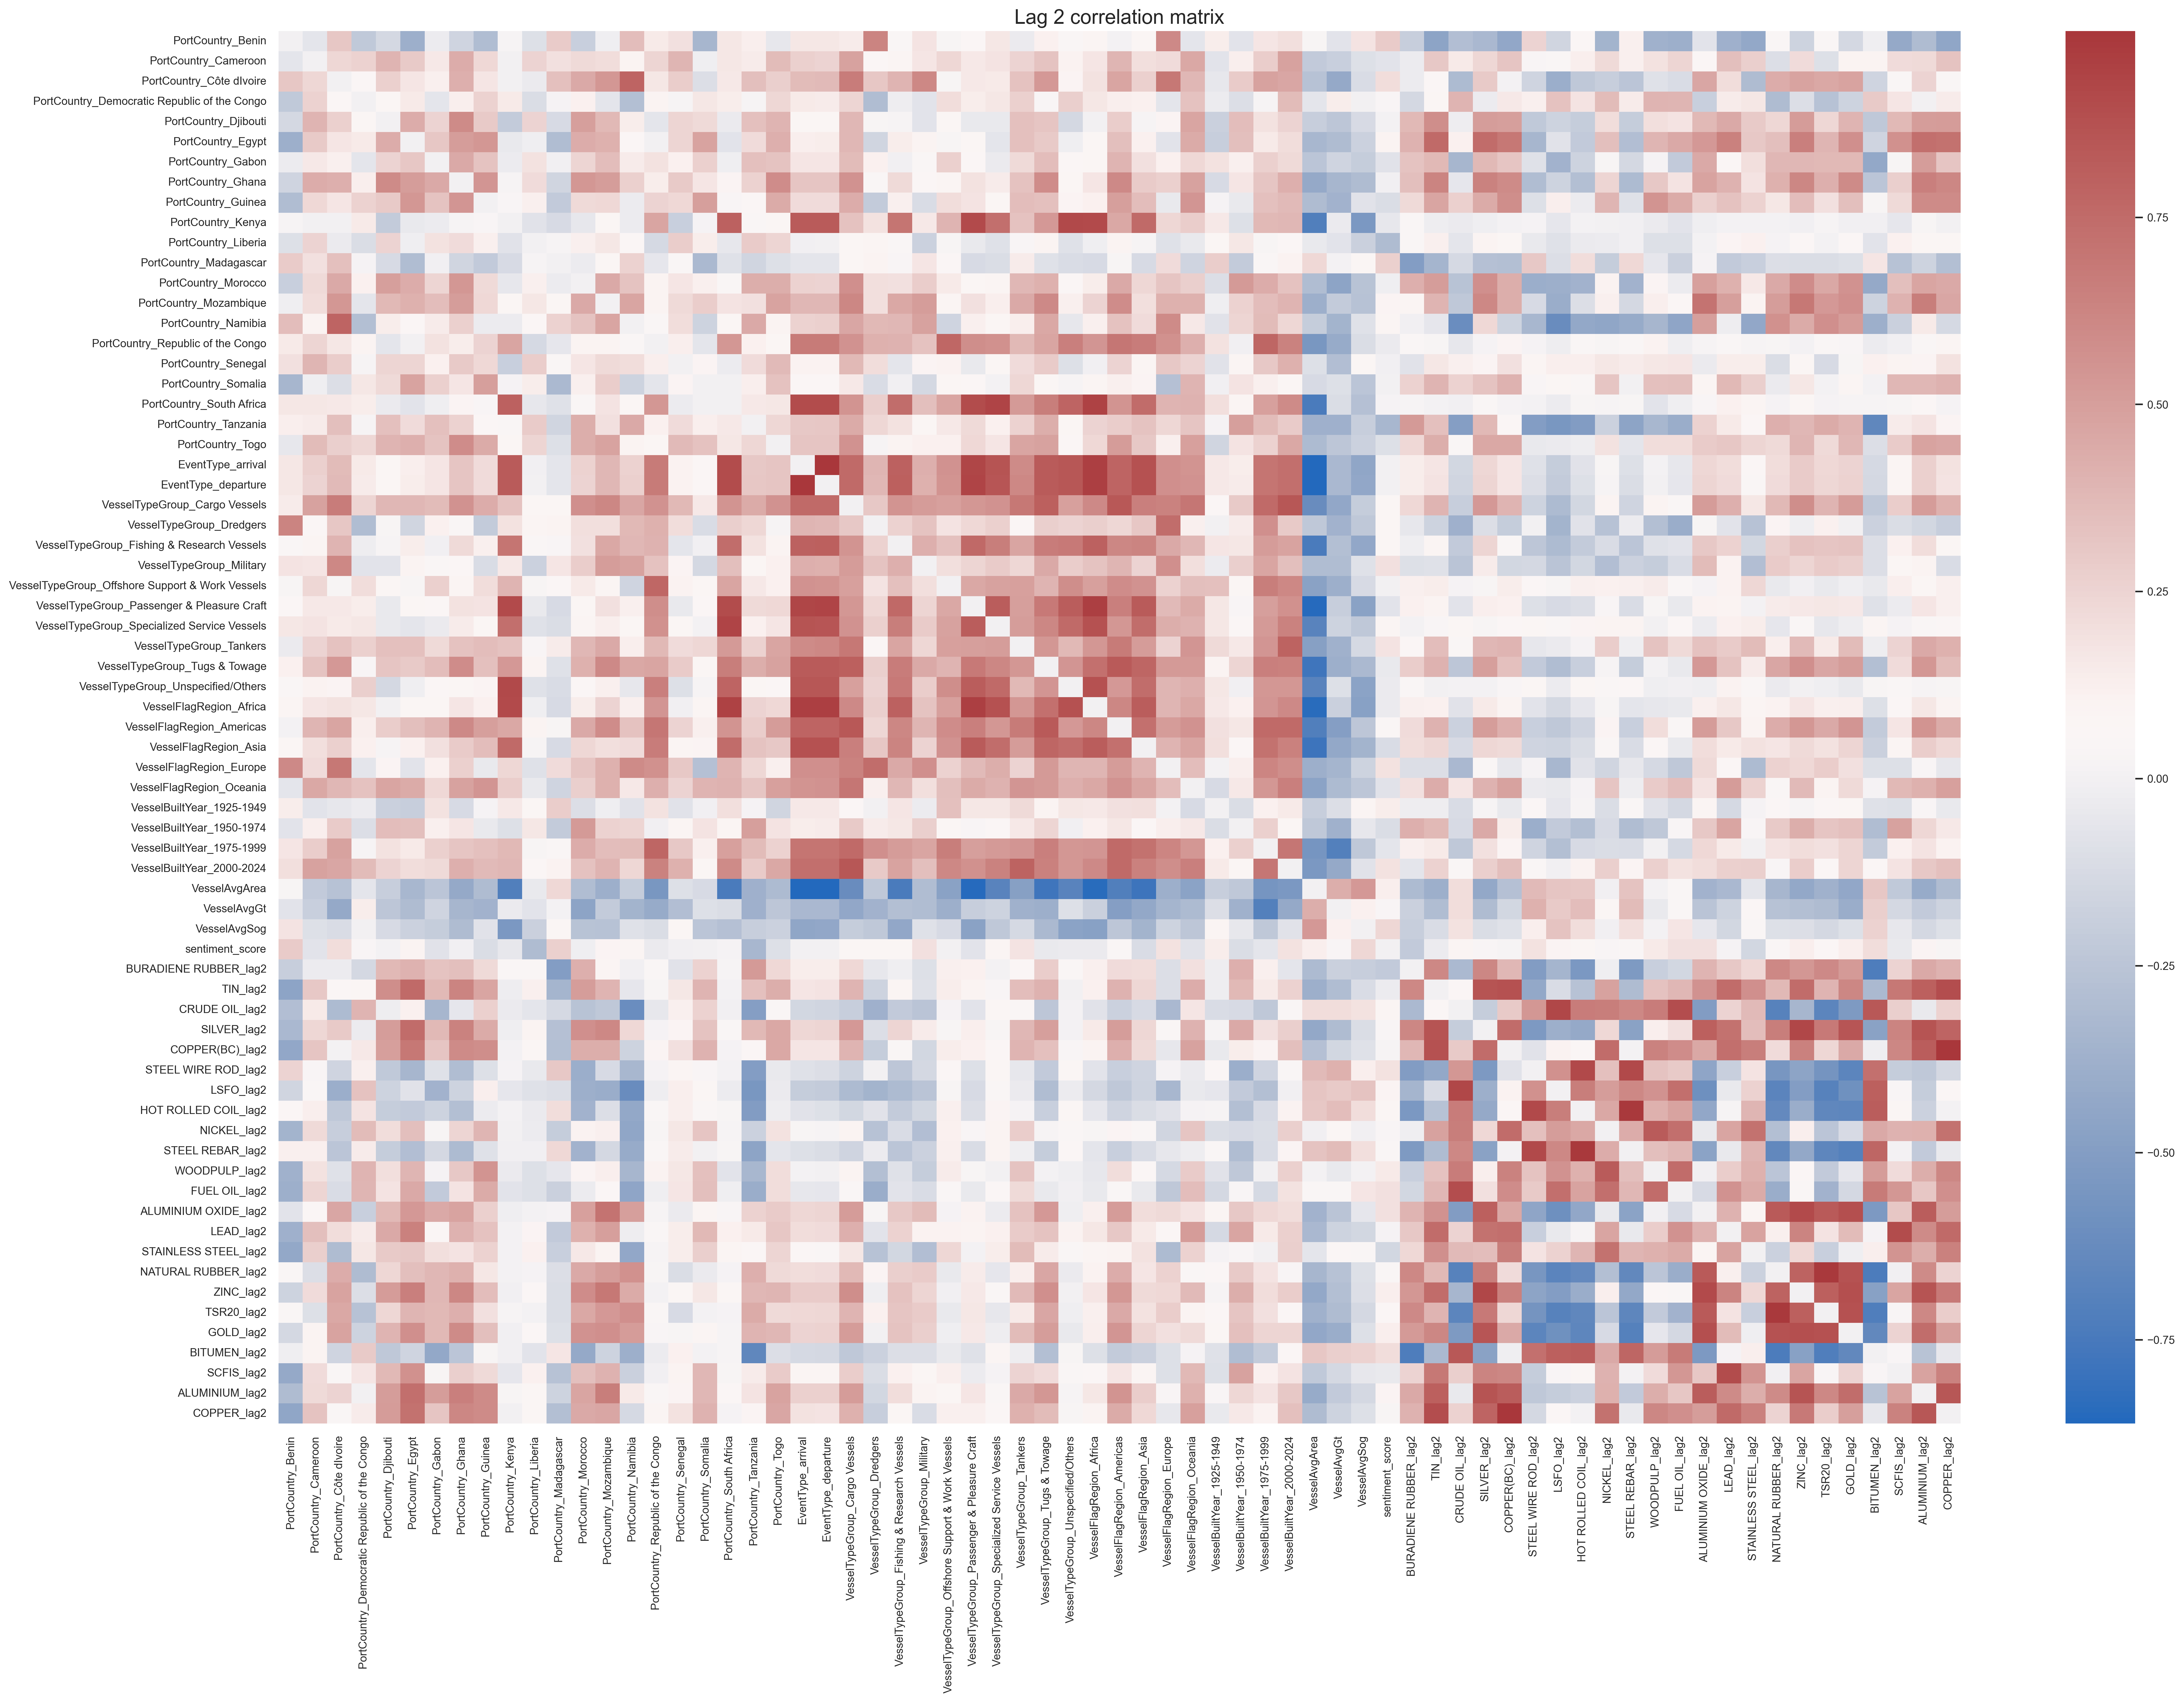

In [42]:
co_mtx = df_l2.corr(numeric_only=True)
co_mtx = co_mtx - np.eye(co_mtx.shape[0])

sns.set(font_scale=0.8)
plt.figure(figsize=(30, 20), dpi=300)
plt.title('Lag 2 correlation matrix', fontdict={'size': 16})
sns.heatmap(co_mtx, cmap="vlag", annot=False)
plt.savefig("../misc/images/Lag2_correlation_heatmap.png")

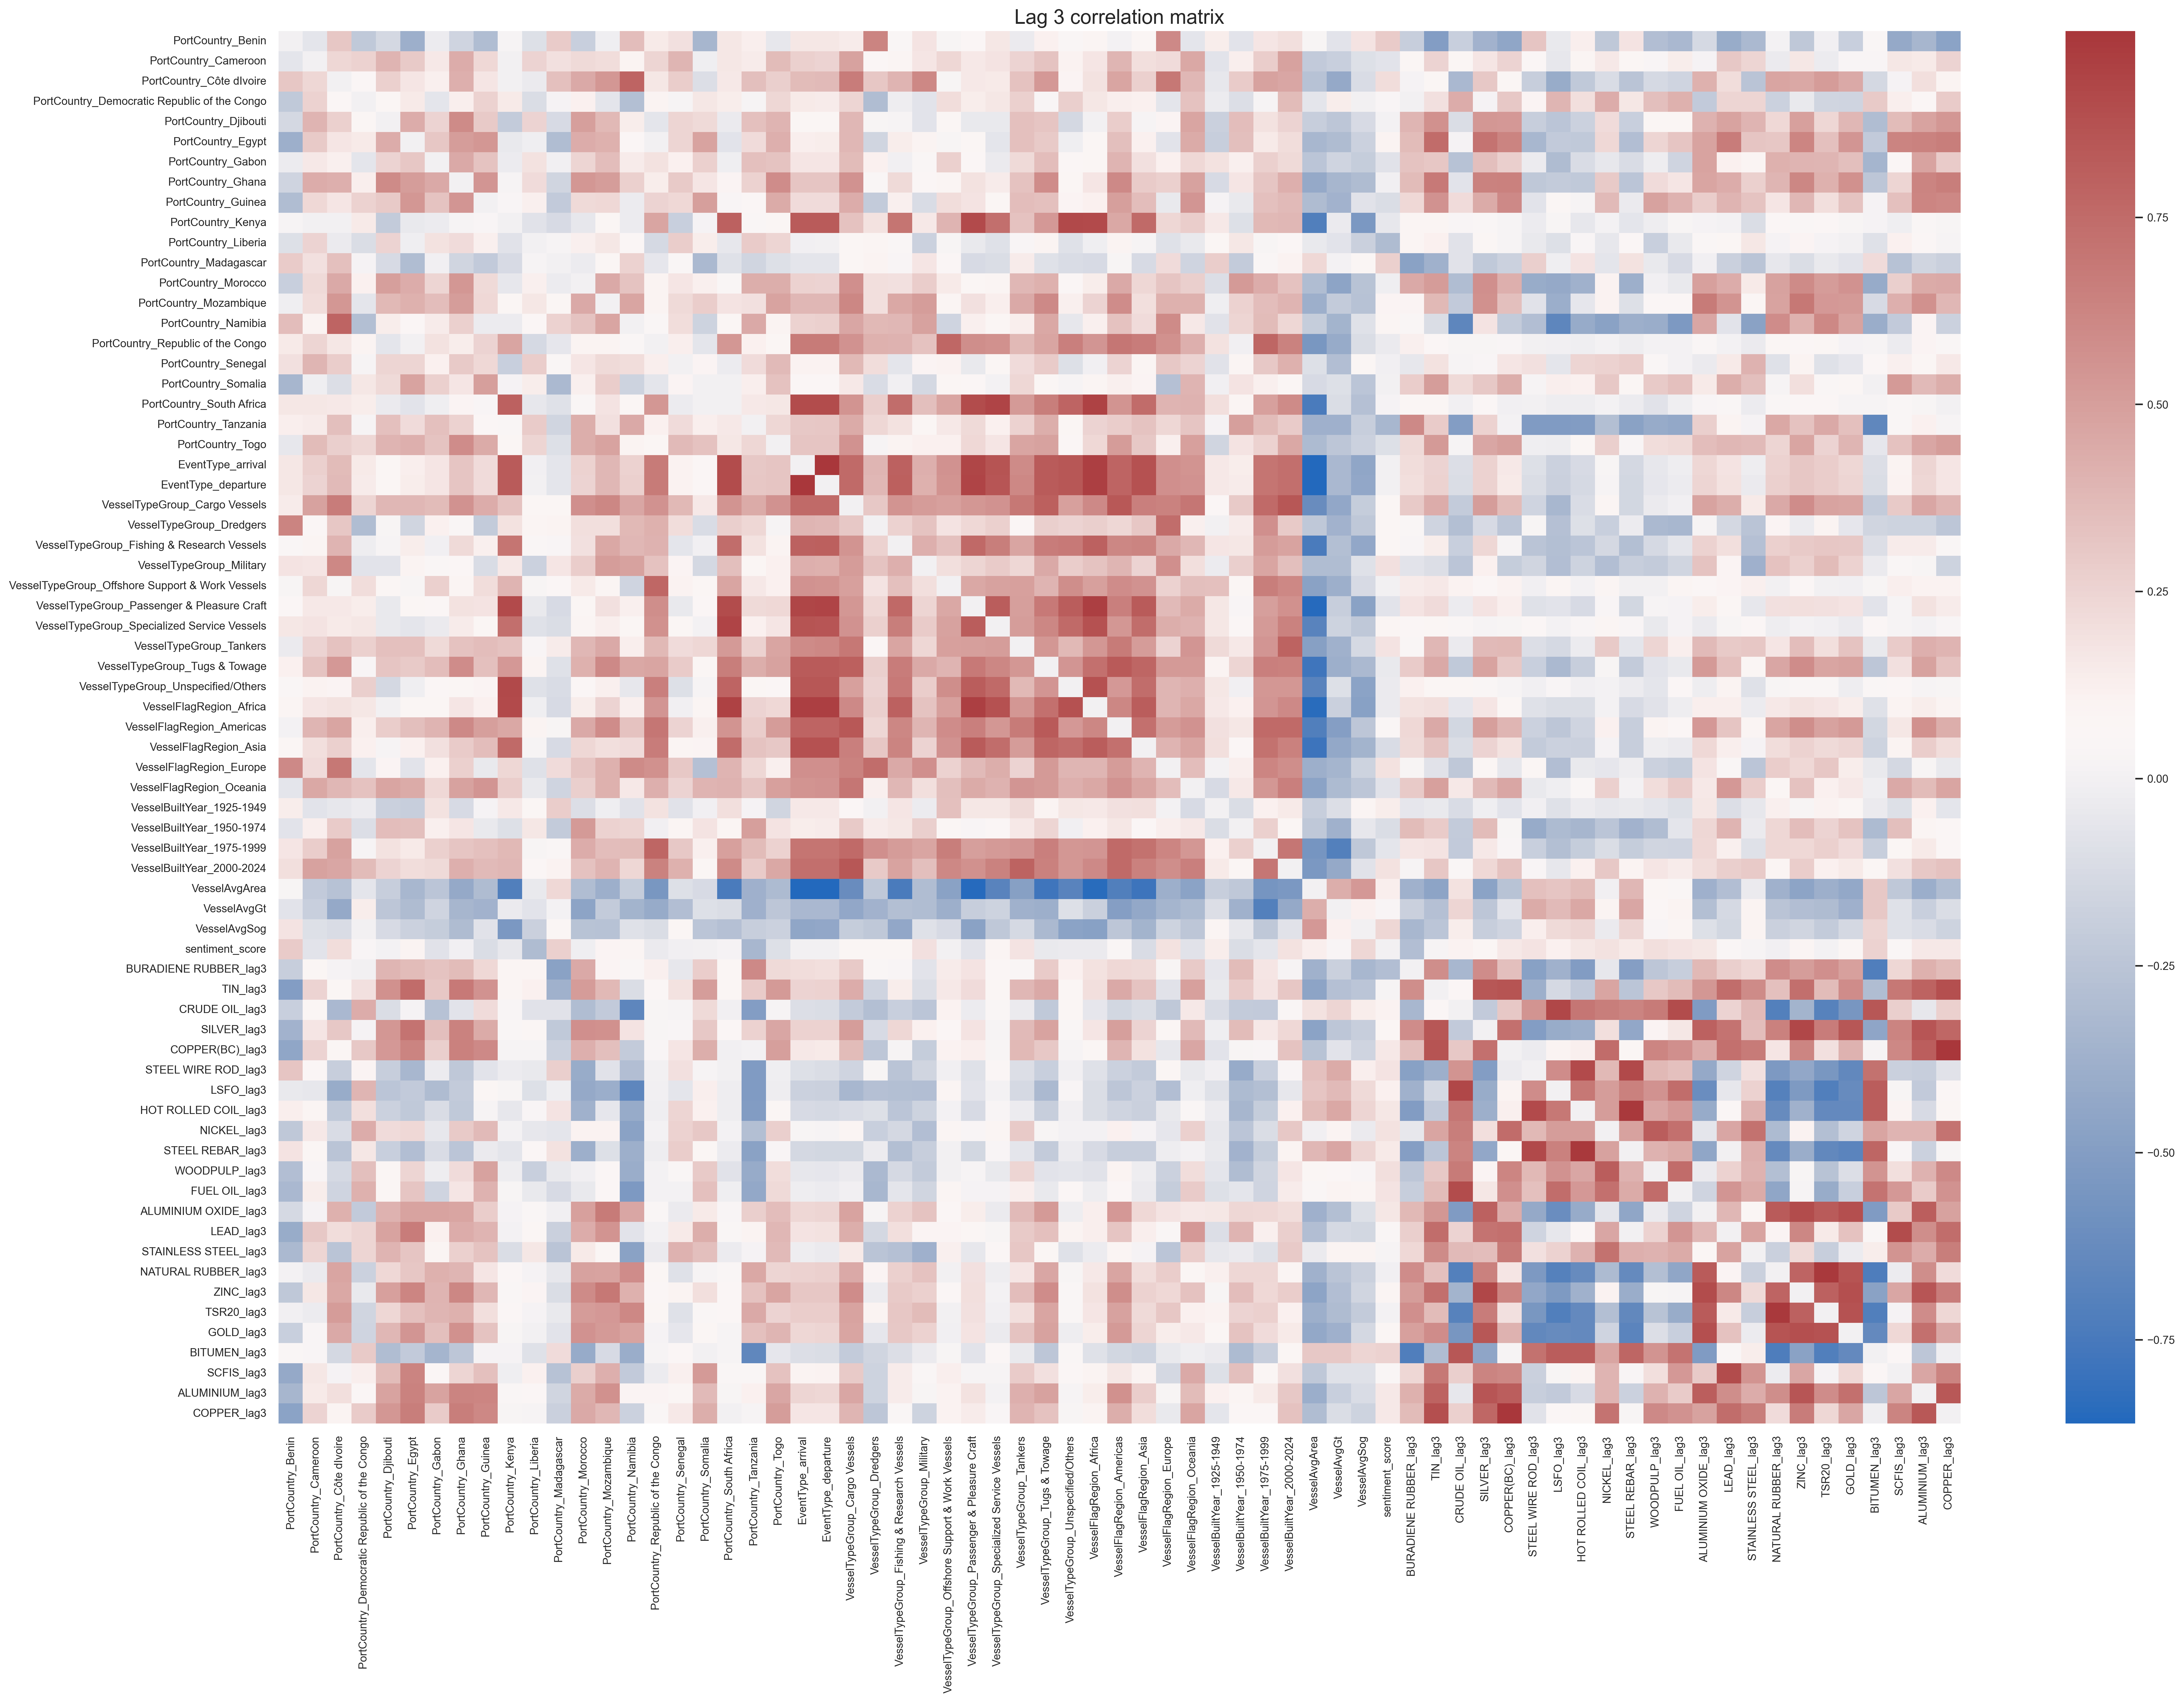

In [43]:
co_mtx = df_l3.corr(numeric_only=True)
co_mtx = co_mtx - np.eye(co_mtx.shape[0])

sns.set(font_scale=0.8)
plt.figure(figsize=(30, 20), dpi=300)
plt.title('Lag 3 correlation matrix', fontdict={'size': 16})
sns.heatmap(co_mtx, cmap="vlag", annot=False)
plt.savefig("../misc/images/Lag3_correlation_heatmap.png")